In [12]:
import gymnasium as gym
import seaborn as sns
import os
from collections import deque, Counter, namedtuple, defaultdict
import random
from matplotlib import pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
import torch
from torch import nn
import torch.nn.functional as F
import math
from itertools import count
from tqdm import tqdm
import numpy as np
import time

#Setting up matplotlib for live update the traiing progress
import matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display


# Env
observations: 8 dim
- coord x:              float
- coord y:              float
- velocity x:           float
- velocity y:           float
- angle:                float
- angular velocity:     float
- is left touched:      boolean
- is right leg touched: boolea

actions: 
- 0: do nothing
- 1: fire left orientation engine
- 2: fire main engine
- 3: fire right orientation engine

rewards:
- is increased/decreased the closer/further the lander is to the landing pad.
- is increased/decreased the slower/faster the lander is moving.
- is decreased the more the lander is tilted (angle not horizontal).
- is increased by 10 points for each leg that is in contact with the ground.
- is decreased by 0.03 points each frame a side engine is firing.
- is decreased by 0.3 points each frame the main engine is firing.


terminated
[ 0.03896379 -0.0080184  -0.5197602   0.07986474  1.7593174   0.6346992
  0.          1.        ]


Text(0.5, 1.0, 'rewards')

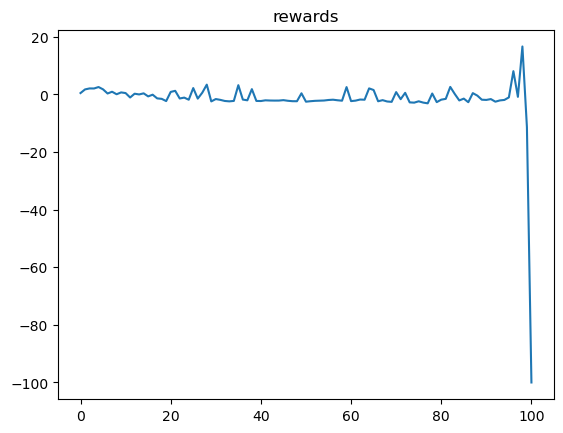

In [13]:
env = gym.make('LunarLander-v2', render_mode = 'human')
obs, info = env.reset(seed = 42)
rewards = []

for t in range(1000):
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    rewards.append(reward)

    if terminated or truncated:
        print('terminated')
        print(obs)
        obs, info = env.reset()
        break
env.close()
sns.lineplot(y = rewards, x = list(range(len(rewards))))
plt.title("rewards")


# Replay Memory

In [14]:
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state'))
class ReplayMemory():
    def __init__(self, capacity) -> None:
        self.capacity = capacity
        self.memory = deque(maxlen = capacity)
    
    def push(self, state, action, reward, next_state):
        self.memory.append(Transition(state, action, reward, next_state))
    
    def sample(self, batch_size):
        if batch_size > len(self.memory): return None
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)
    
    def clear(self):
        self.memory.clear()

In [15]:
#Test memory
memory = ReplayMemory(capacity=10)

for _ in range(10):
    state = random.randint(0,8)
    action = random.randint(0,3)
    reward = random.randint(-10, 10)
    next_state = random.randint(0,8)
    memory.push(state, action, reward, next_state)

batch = memory.sample(5)
print(batch)


[Transition(state=2, action=1, reward=-6, next_state=5), Transition(state=7, action=1, reward=-10, next_state=5), Transition(state=1, action=0, reward=-5, next_state=7), Transition(state=0, action=3, reward=1, next_state=2), Transition(state=1, action=1, reward=-3, next_state=2)]


# DQN network

In [16]:
class DQN(nn.Module):

    def __init__(self, n_observation, n_actions) -> None:
        super().__init__()
        self.layer1 = nn.Linear(n_observation, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)
    
    def forward(self, X):
        X = F.relu(self.layer1(X))
        X = F.relu(self.layer2(X))
        #we're not using activation function in here
        return self.layer3(X)
        

In [17]:
sample_state = torch.rand(8)
print(sample_state)
dqn = DQN(n_observation=8, n_actions=4)
sample_actions = dqn(sample_state).unsqueeze(0)
print(sample_actions)
print(sample_actions.max(1).indices.view(1,1))

tensor([0.5986, 0.9243, 0.0799, 0.1060, 0.4694, 0.1650, 0.2519, 0.8133])
tensor([[-0.0517, -0.0997,  0.0848, -0.0010]], grad_fn=<UnsqueezeBackward0>)
tensor([[2]])


# Greedy epsilon 

In [18]:
def select_action(state, epsilon, env, policy_net, device):
    '''
    @params:
        state: np.array[int]
        epsilon: in
        env: Gym.Env
        policy_net: nn.Module
        device: str
    @returns:
        action: torch.tensor shape = (1,)
    '''
    prob = random.random()
    state = torch.tensor(state, dtype = torch.float32)
    #exploit
    if prob > epsilon: 
        return policy_net(state).max(1).indices.view(1)
    else:
        return torch.tensor([env.action_space.sample()], device = device, dtype = torch.long)

def calculate_epsilon(step, max_ep, min_ep, decay_ep):
    return min_ep + (max_ep - min_ep) * math.exp(-(step / decay_ep))

<Axes: >

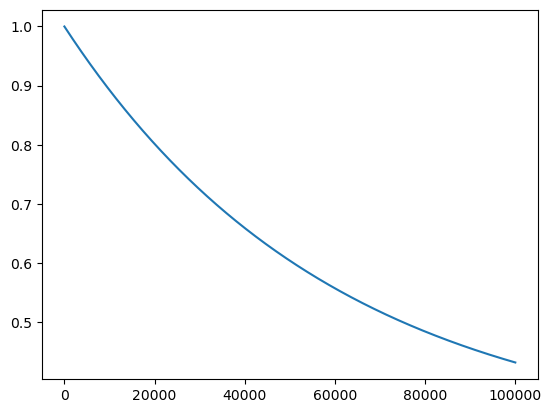

In [19]:
eps = []
for t in range(100000):
    eps.append(calculate_epsilon(t, 1.0,0.3,60000))
sns.lineplot(y = eps, x = list(range(len(eps))))



In [20]:
# a =  torch.tensor([[env.action_space.sample()]], dtype = torch.long)
# print(a.shape)
# state = torch.tensor(state, dtype = torch.float32)
# #exploit
# dqn = DQN(8, 4)
# b= dqn(state).max(1).indices.view(1,1)
# print(b.shape)

torch.Size([1, 1])


RuntimeError: both arguments to matmul need to be at least 1D, but they are 0D and 2D

In [22]:
for t in range(10):
    epsilon = calculate_epsilon(t, 0.99, 0.1, 10000)
    print(epsilon)

dqn = DQN(8, 4)
print(select_action(torch.randint(0,4,(1,1)), epsilon, env, dqn, 'cpu'))

0.99
0.9899110044498517
0.9898220177988134
0.9897330400459953
0.9896440711905077
0.9895551112314607
0.9894661601679648
0.9893772179991306
0.9892882847240685
0.9891993603418894
tensor([0])


# Optimize model

In [23]:
a = map(lambda x: x + 1, [1,2,3,4,5,6])
print(a)

In [24]:
def optimize(memory, batch_size, policy_net, target_net, optimizer, criterion, grad_clip = 100, gamma = 0.99, device = 'cpu', debug = False):

    #if batch < len(memory)
    if len(memory) < batch_size: return

    batch = memory.sample(batch_size)

    transitions = Transition(*zip(*batch))
    # print(len(transitions.state))

    state_batch = torch.cat(transitions.state) 
    action_batch = torch.cat(transitions.action) 
    reward_batch = torch.cat(transitions.reward) 
    # next_state_batch = torch.cat(transitions.next_state) 

    # print('state batch = \n', state_batch)
    # print(f'action batch {action_batch.shape} = \n',  action_batch)
    # print('reward batch = \n', reward_batch)
    # print('next state')
    # print(transitions.next_state)

    #temporal difference loss = Q(s,a) - (r + gamma * Q(s',a'))
    #get Q(s,a) from policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)
    # print(state_action_values)

    # get the Q(s',a') from target_net
    non_final_next_states = torch.cat([s for s in transitions.next_state if s != None])
    target_net_output = target_net(non_final_next_states)

    expected_state_action_values = torch.zeros(batch_size, device = device)

    non_final_next_state_mask = torch.tensor(tuple(map(lambda s: s != None, transitions.next_state)), device = device)
    # print(non_final_next_state_mask)
    expected_state_action_values[non_final_next_state_mask] = target_net_output.max(1).values
    # print(f'next_state_action_values (shape = {next_state_action_values.shape})\n', next_state_action_values)

    #calculate target = (reward + gamma * Q(s',a'))
    expected_state_action_values = reward_batch + (gamma * expected_state_action_values)
    # print(f'state_action_values (shape = {state_action_values.shape})\n', state_action_values)
    # print(f'expected_state_action_values (shape = {expected_state_action_values.shape})\n', expected_state_action_values)

    #state action values shape = (batch_size, 1)
    #expected state action values shape = (batch_size, batch_size)
    #TODO: why batch size x batch_size ????

    optimizer.zero_grad()

    loss = criterion(state_action_values, expected_state_action_values)
    # print('loss value = ', loss.item())

    loss.backward()
    #clip grad to prevent exploding gradient
    nn.utils.clip_grad_value_(policy_net.parameters(), grad_clip)

    optimizer.step()

In [25]:
# memory
memory = ReplayMemory(capacity=10)

env = gym.make('LunarLander-v2', render_mode = 'human')
state, info = env.reset()

observation_n = len(state)
print('observation n = ', observation_n)
action_n = env.action_space.n
print('action n = ', action_n)

policy_net = DQN(observation_n, action_n)
target_net = DQN(observation_n, action_n)

for _ in range(20):
    state = torch.rand((1,observation_n))
    next_state = torch.rand((1,observation_n))
    reward = torch.randint(-10,10, (1,1))
    action = torch.randint(0,4, (1,1))

    memory.push(state, action, reward, next_state)

    state = next_state


optimizer = torch.optim.AdamW(policy_net.parameters(), lr = 0.001)
criterion = nn.SmoothL1Loss()

GAMMA = 0.9

optimize(memory, 5, policy_net=policy_net, target_net=target_net, optimizer=optimizer, criterion=criterion, gamma=GAMMA)
env.close()



observation n =  8
action n =  4


# Training loop

In [26]:
ROOT = os.getcwd()
OUTPUT = os.path.join(ROOT, 'output', 'lunar')
if os.path.exists(OUTPUT) == False:
    os.makedirs(OUTPUT)

In [27]:
def tune(
    gamma, batch_size, lr, 
    training_episodes, max_ep, min_ep, decay_ep, 
    grad_clip = 10, target_net_update_freq = 10, device = 'cpu', tau = 0.005, fig_update_freq = 50): 
    #the TAU constant is for soft update when synchronize the policy and target net
    assert os.path.exists(OUTPUT), 'output to save model not found'

    env = gym.make('LunarLander-v2', render_mode = 'human')

    memory = ReplayMemory(capacity=10)
    obs, info = env.reset()
    observation_n = len(obs)
    action_n = env.action_space.n

    print('observation n = ', observation_n)
    print('action n = ', action_n)

    policy_net = DQN(observation_n, action_n)
    target_net = DQN(observation_n, action_n)

    optimizer = torch.optim.AdamW(policy_net.parameters(), lr = 0.001)
    criterion = nn.SmoothL1Loss()
    history = defaultdict(list)
    step = 0
    sync_count = 0

    loop = tqdm(range(training_episodes))
    best_reward = 0
    
    for episode in loop: 

        state, info = env.reset()
        state = torch.tensor(state, device = device, dtype = torch.float32).unsqueeze(0)
        total_reward = 0

        for t in count():
            epsilon = calculate_epsilon(step, max_ep, min_ep, decay_ep)
            step += 1
            action = select_action(state, epsilon, env, policy_net, device)
            next_state, reward, terminated, truncated, info = env.step(action.item())
            done = terminated or truncated

            total_reward += reward

            if terminated:
                next_state = None
            else:
                next_state = torch.tensor(next_state, device = device, dtype = torch.float32).unsqueeze(0)
            
            reward = torch.tensor(reward).unsqueeze(0)
            action = action.unsqueeze(0)
            
            memory.push(state, action, reward, next_state)

            state = next_state

            optimize(memory, batch_size, policy_net, target_net,optimizer, criterion, gamma = gamma, grad_clip=grad_clip)

            #soft update target net every C step
            #link: https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
            if step % target_net_update_freq == 0:
                sync_count += 1
                policy_net_state_dict = policy_net.state_dict()
                target_net_state_dict = target_net.state_dict()

                for key in policy_net_state_dict:
                    target_net_state_dict[key] = policy_net_state_dict[key] * tau + target_net_state_dict[key] * (1 - tau)
                
                target_net.load_state_dict(target_net_state_dict)
            loop.set_description(f'epoch = {episode}, epsilon = {epsilon:.3f}, total reward = {total_reward:.3f}, sync count = {sync_count}')
            
            if done: 
                break

            history['epsilon'].append(epsilon)
                
        history['reward'].append(total_reward)

        if best_reward < total_reward:
            best_reward = total_reward
            torch.save(policy_net, os.path.join(OUTPUT, 'policy_net.checkpoint.torch'))
            torch.save(target_net, os.path.join(OUTPUT, 'target_net.checkpoint.torch'))

        if episode % fig_update_freq == 0:
            plot(history, 'lunar_landar.dqn.png')
    #close training loop
    env.close()
    return history

def plot(history, savepath = None, show = False):
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))
    sns.lineplot(y = history['reward'], x = list(range(len(history['reward']))), ax = ax1, color='red')
    ax1.set_title("Reward per episodes")
    sns.lineplot(y = history['epsilon'], x = list(range(len(history['epsilon']))), ax = ax2)
    ax2.set_title("Epsilone decay")
    if savepath:
        plt.savefig(savepath)
    plt.close()
    # if show:
    #     plt.show()

In [28]:
GAMMA = 0.9
BATCH_SIZE = 10 
LR = 0.001
TRAINING_EPISODES = 1000
MAX_EPSILON = 1.0
MIN_EPSILON = 0.1
DECAY_EPSILON = 60000
TARGETNET_UPDATE_FREQ = 50

params = [GAMMA, BATCH_SIZE, LR, TRAINING_EPISODES, MAX_EPSILON, MIN_EPSILON, DECAY_EPSILON, TARGETNET_UPDATE_FREQ]
history = tune(*params, fig_update_freq=50)


observation n =  8
action n =  4


epoch = 686, epsilon = 0.235, total reward = 31.590, sync count = 11383:  69%|██████▊   | 686/1000 [40:36<18:35,  3.55s/it]   


KeyboardInterrupt: 